# Project 3. Predicting hourly demand for bycicle-rental 

## 1. Defining the goal of the project 

The goal of this project is to predict the total count of bycicles rented during each hour based on time and weather features, optimizing the accuracy of the model for RMSLE.

Using the "Bike Sharing Demand" data set from Kaggle website that provides hourly rental data spanning two years. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. We predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

More information on the data fields: 

https://www.kaggle.com/c/bike-sharing-demand/data


In [1]:
# Importing Libraries

# EDA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Feature Selection
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from statsmodels.api import OLS 

# Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score

# Cross Validation 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import (KFold, ShuffleSplit, StratifiedKFold)
from sklearn.model_selection import cross_val_score 

## 2. Getting the data:

In [2]:
# loading training set, pandas parse the column 'dates' and turn them into datetime: parse_dates=True
train_set = pd.read_csv('../data/train.csv', index_col=0, parse_dates=True)

In [3]:
train_set.shape

(10886, 11)

In [4]:
train_set.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


## 3. Preparing dataset to Train-Test Splitting

### 3.1. The variables of the dataset:



    datetime - date and hour
    season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
    holiday - whether the day is considered a holiday
    workingday - whether the day is neither a weekend nor holiday
    weather
    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    temp - temperature in Celsius
    atemp - "feels like" temperature in Celsius
    humidity - relative humidity
    windspeed - wind speed
    casual - number of non-registered user rentals initiated
    registered - number of registered user rentals initiated
    count - number of total rentals


### 3.2. Extracting time features from the DatetimeIndex

In [5]:
# Extracting hour, weekday, month and year from datetime 
train_set['hour'] = train_set.index.hour
train_set['weekday'] = train_set.index.weekday
train_set['month'] = train_set.index.month
train_set['year'] = train_set.index.year

In [6]:
train_set.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday,month,year
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1,2011
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1,2011


### 3.3. Removing variables against potential data leackages from the dataset

In [7]:
X = train_set.drop(train_set[['count']], axis=1)
y = train_set['count']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [9]:
X_train.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,hour,weekday,month,year
datetime,,,,,,,,,,,,,,
2011-06-18 19:00:00,2,0,0,2,30.34,33.335,51,7.0015,99,227,19,5,6,2011
2012-09-08 17:00:00,3,0,0,3,23.78,27.275,83,12.9980,52,119,17,5,9,2012


In [10]:
y_test.head(2)

datetime
2012-07-10 13:00:00    280
2012-10-07 13:00:00    320
Name: count, dtype: int64

## 3. Exploratory data analysis (EDA):

In [7]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [11]:
# redefining X, dropping casual and registered as well 
X = train_set.drop(train_set[['casual', 'registered', 'count']], axis=1)
y = train_set['count']

In [12]:
X.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,month,year
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,0,5,1,2011
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,1,5,1,2011


### 3.3. Inspecting descriptive statistics of your features and the target variable

In [13]:
train_set.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday,month,year
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613,3.013963,6.521495,2011.501929
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838,2.004585,3.444373,0.500019
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2011.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000,1.000000,4.000000,2011.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000,3.000000,7.000000,2012.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000,5.000000,10.000000,2012.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000,6.000000,12.000000,2012.000000


### 3.4. Visualize the relationships between single features and the target variable

In [14]:
resampled = train_set.resample('M').sum()

In [15]:
resampled.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday,month,year
datetime,,,,,,,,,,,,,,,
2011-01-31,431,24,264,621,3721.16,4641.000,24269,5926.1768,2008,21544,23552,5135,1304,431,866741
2011-02-28,446,0,327,615,5053.66,6243.965,23897,6917.1470,3776,29068,32844,5208,1338,892,896906
2011-03-31,446,0,328,654,6272.18,7535.435,24942,7151.1043,7910,30825,38735,5211,1339,1338,896906
2011-04-30,910,24,287,737,8088.48,9664.125,30160,7209.1263,12229,38288,50517,5241,1392,1820,915005
2011-05-31,912,0,336,697,9817.04,11607.545,32568,5634.0434,15865,63848,79713,5244,1296,2280,917016
2011-06-30,912,0,312,583,12855.14,14660.815,26581,5440.1253,19600,70176,89776,5244,1488,2736,917016
2011-07-31,1368,24,288,540,13665.30,15509.315,27544,5454.1216,26145,66703,92848,5244,1392,3192,917016
2011-08-31,1368,0,360,613,13528.36,15258.540,28348,5691.1274,17580,65716,83296,5244,1248,3648,917016
2011-09-30,1359,24,285,733,11388.98,12998.045,33898,5210.1545,18311,60793,79104,5238,1436,4077,910983


<AxesSubplot:xlabel='workingday', ylabel='count'>

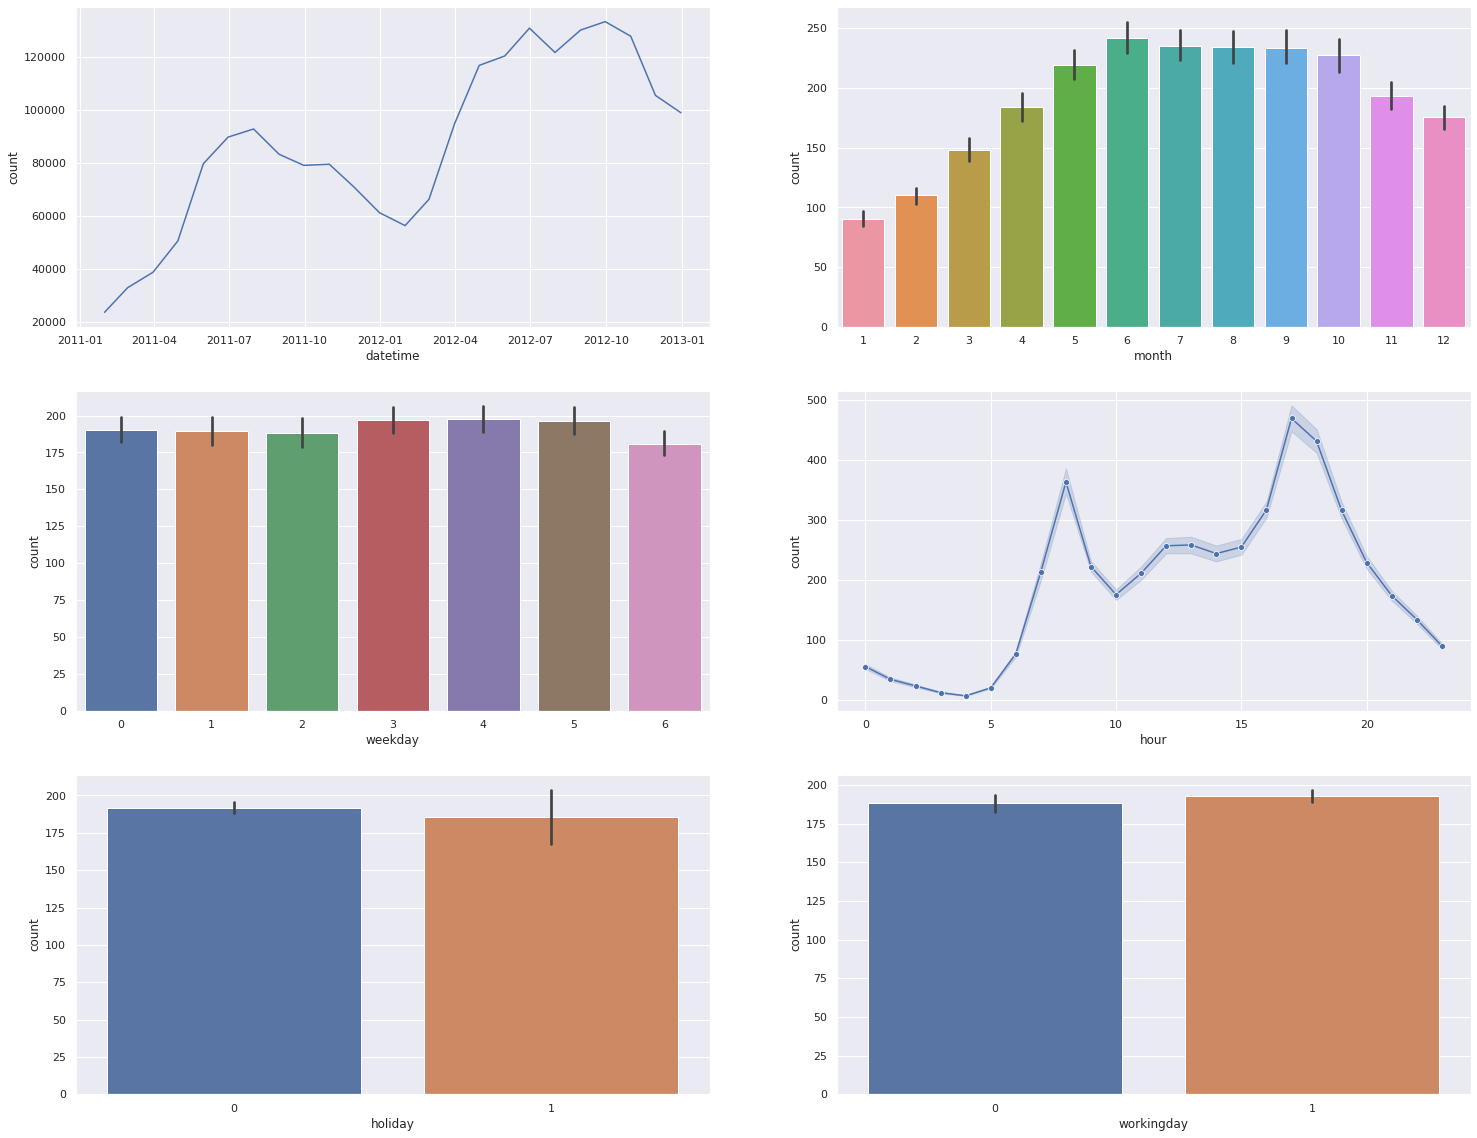

In [15]:
# plotting time related variables 
plt.figure(figsize=(25,20))
sns.set_theme()
plt.subplot(3,2,1)
sns.lineplot(data=resampled, x=resampled.index, y='count')
plt.subplot(3,2,2)
sns.barplot(data=train_set, x='month',y='count',estimator=np.mean)
plt.subplot(3,2,3)
sns.barplot(data=train_set,x='weekday',y='count',estimator=np.mean)
plt.subplot(3,2,4)
sns.lineplot(data=train_set,x='hour',y='count', marker='o', estimator=np.mean)
plt.subplot(3,2,5)
sns.barplot(data=train_set, x="holiday", y="count", estimator=np.mean)
plt.subplot(3,2,6)
sns.barplot(data=train_set, x="workingday", y="count",  estimator=np.mean)


<AxesSubplot:xlabel='windspeed', ylabel='count'>

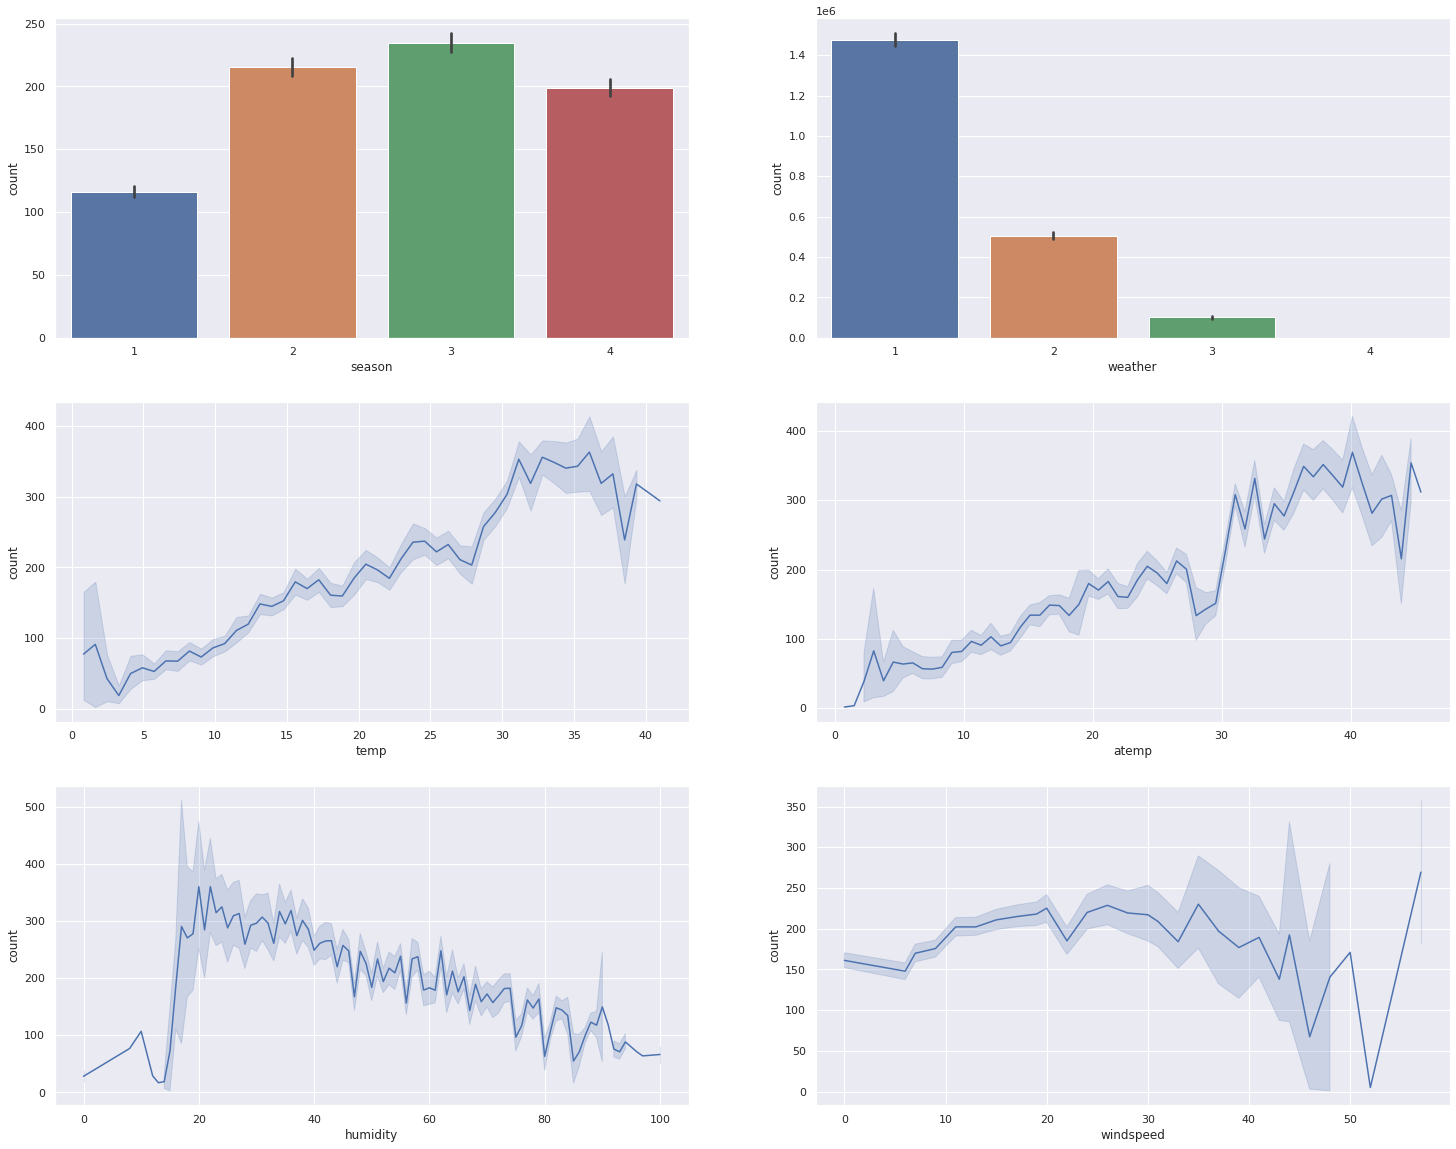

In [16]:
# Plotting weather related variables
plt.figure(figsize=(25,20))
sns.set_theme()
plt.subplot(3,2,1)
sns.barplot(x="season", y="count", data=train_set, estimator=np.mean)
plt.subplot(3,2,2)
sns.barplot(x="weather", y="count", data=train_set, estimator=np.sum)
plt.subplot(3,2,3)
sns.lineplot(x="temp", y="count", data=train_set)
plt.subplot(3,2,4)
sns.lineplot(x="atemp", y="count", data=train_set) 
plt.subplot(3,2,5)
sns.lineplot(x="humidity", y="count", data=train_set) 
plt.subplot(3,2,6)
sns.lineplot(x="windspeed", y="count", data=train_set)

### 3.5. Correlations between predicators and target / Multicollinearity - Feature Selection

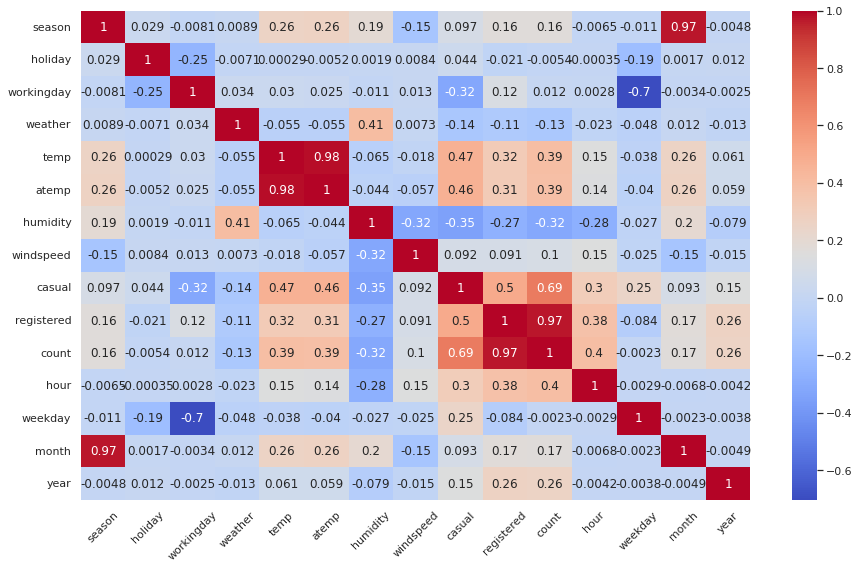

In [17]:
plt.figure(figsize=(15,9)) 
ax = sns.heatmap(train_set.corr(),annot=True, cmap='coolwarm')
ax.tick_params(axis='x', rotation=45)

### 3.5.1 Variance Inflation Factor 

In [18]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [22]:
vif_data

,feature
0,season
1,holiday
2,workingday
3,weather
4,temp
5,atemp
6,humidity
7,windspeed
8,hour
9,weekday


In [23]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

       feature         VIF
0       season  109.474112
1      holiday    1.565106
2   workingday    9.064293
3      weather    7.508942
4         temp  276.719498
5        atemp  315.197703
6     humidity   17.493027
7    windspeed    4.161167
8         hour    4.247420
9      weekday    9.196941
10       month   83.524540
11        year   67.055738


In [24]:
X2 = X.drop(['atemp'], axis=1)
vif_data_2 = pd.DataFrame()
vif_data_2["feature"] = X2.columns
vif_data_2["VIF"] = [variance_inflation_factor(X2.values, i)
                          for i in range(len(X2.columns))]
print(vif_data_2)

       feature         VIF
0       season  109.473980
1      holiday    1.555623
2   workingday    8.995152
3      weather    7.501700
4         temp    8.588453
5     humidity   17.444028
6    windspeed    3.992635
7         hour    4.242934
8      weekday    9.130404
9        month   83.521942
10        year   63.049357


In [25]:
X3 = X.drop(['atemp', 'season'], axis=1)
vif_data_3 = pd.DataFrame()
vif_data_3["feature"] = X3.columns
vif_data_3["VIF"] = [variance_inflation_factor(X3.values, i)
                          for i in range(len(X3.columns))]
print(vif_data_3)

      feature        VIF
0     holiday   1.542563
1  workingday   8.994986
2     weather   7.501312
3        temp   8.578762
4    humidity  17.420442
5   windspeed   3.991422
6        hour   4.242130
7     weekday   9.129221
8       month   5.245527
9        year  59.644012


In [26]:
X4 = X.drop(['atemp', 'season', 'year'], axis=1)
vif_data_4 = pd.DataFrame()
vif_data_4["feature"] = X4.columns
vif_data_4["VIF"] = [variance_inflation_factor(X4.values, i)
                          for i in range(len(X4.columns))]
print(vif_data_4)

      feature        VIF
0     holiday   1.293959
1  workingday   5.460216
2     weather   7.469605
3        temp   7.728628
4    humidity  12.879300
5   windspeed   3.464645
6        hour   3.925416
7     weekday   5.321123
8       month   5.203902


Result of VIF: drop 'atemp', 'season', 'year', 'humidity'

### 3.5.2. Recursive feature elimination (RFE)

In [27]:
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=8, step=1)
selector = selector.fit(X, y)

selector.support_

array([ True,  True,  True, False,  True, False,  True, False,  True,
       False,  True,  True])

In [28]:
selector.ranking_

array([1, 1, 1, 4, 1, 3, 1, 5, 1, 2, 1, 1])

In [29]:
X.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,month,year
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,0,5,1,2011
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,1,5,1,2011


Result of RFE: drop 'weather', 'atemp', 'windspeed', 'weekday'

Decidide to drop: 
    season, (because of month)
    holiday 
    workingday
    weather
    atemp (because of temp) 
    weekday   
    windspeed
    
Keeping features:
temp 
humidity
hour
month
year


In [19]:
# redefining X, dropping more features: 
X = train_set.drop(train_set[['casual', 'registered', 'count', 'season', 'holiday', 'workingday', 'weather', 'atemp', 'weekday', 'windspeed']], axis=1)
y = train_set['count']

In [20]:
X.head(2)

,temp,humidity,hour,month,year
datetime,,,,,
2011-01-01 00:00:00,9.84,81,0,1,2011
2011-01-01 01:00:00,9.02,80,1,1,2011


### 3.6. Checking Missing Values:

In [100]:
X.isnull().sum()

weather     0
temp        0
humidity    0
hour        0
weekday     0
month       0
year        0
dtype: int64

<AxesSubplot:>

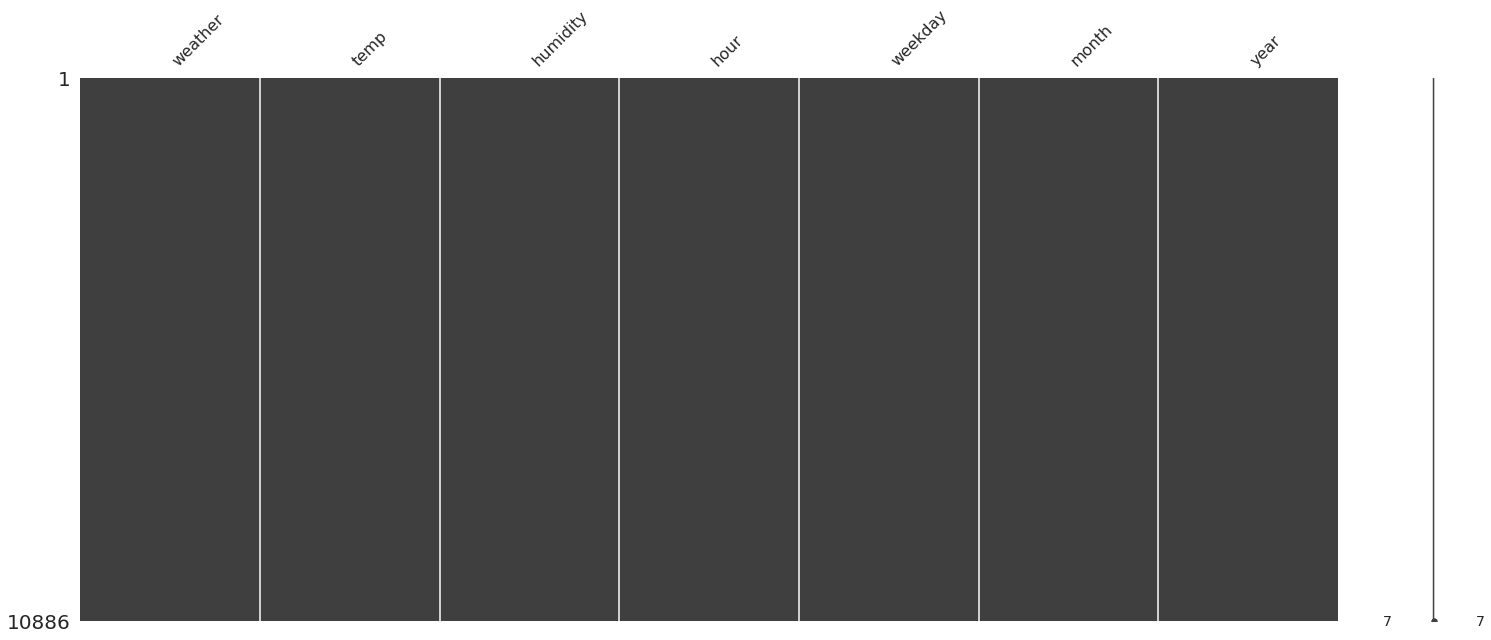

In [111]:
msno.matrix(X)

There are no missing values, therefore no need for dropna or impute

### 3.7 Dropping 4. value in weather column

Weather column has only one 4 value. After train-test split, I got an error message at column transformation step that in this column there is an unknown value in the test data, therefore I removed this only one 4 value from weather in the train_set.

In [191]:
# train_set['weather'].value_counts()

In [ ]:
# train['weather'][train['weather']==4] = 3
# test[test['weather']==4] = 3

In [192]:
#train_set.loc[train_set['weather']==4]

In [193]:
#train_set.drop('2012-01-09 18:00:00', inplace=True)

In [194]:
#train_set['weather'].value_counts()

In [195]:
#train_set.shape

In [21]:
# redefining X, dropping more features: 
X = train_set.drop(train_set[['casual', 'registered', 'count', 'season', 'holiday', 'workingday', 'atemp', 'windspeed']], axis=1)
y = train_set['count']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

## 5. Feature Engineering with ColumnTransformer

temp        cont. numerical Scaling
humidity    cont. numerical Scaling
hour        0-23 Scaling
month       0-11 OneHotEncoder
year        2011, 2012 OneHotEncoder
weekday     0-6 OneHotEncoder
weather     1-3 OneHotEncoder

OneHotEncoder: month, year, weekday, weather
MinMaxScaler: temp, humidity, hour

In [23]:
column_transformer = ColumnTransformer([
    ('cat_ohe', OneHotEncoder(handle_unknown = 'ignore'), ['month', 'year', 'weekday', 'weather']),
    ('num_scaler', MinMaxScaler(), ['temp', 'humidity', 'hour',]) 
])

In [24]:
X_train.columns

Index(['weather', 'temp', 'humidity', 'hour', 'weekday', 'month', 'year'], dtype='object')

In [25]:
column_transformer.fit(X_train)
X_train_fe = column_transformer.transform(X_train)
X_test_fe = column_transformer.transform(X_test)

In [31]:
#X_train_FE = pd.DataFrame(data=X_train_fe, columns=column_transformer.get_feature_names())
#X_train_df.head(3) 

## 6. Training Model

### 6.1. Multiple Linear Regression 

In [32]:
PoReg = PoissonRegressor()

In [33]:
PoReg.fit(X_train_fe, y_train)

PoissonRegressor()

In [34]:
PoReg.score(X_train_fe, y_train)

0.4336737964963636

In [35]:
PoReg.score(X_test_fe, y_test)

0.4285111443331976

In [36]:
PoReg.coef_, PoReg.intercept_

(array([-0.36473444, -0.28092376, -0.14749771, -0.04629429,  0.13113752,
         0.01334977, -0.13643746, -0.05167368,  0.16303493,  0.27058541,
         0.20876594,  0.24068914, -0.21588982,  0.21589119, -0.02654207,
        -0.00323312, -0.00181783,  0.01519134,  0.02359572,  0.03026424,
        -0.03745691,  0.06187563,  0.10070938, -0.16258364,  1.33223802,
        -0.99786352,  1.02833317]),
 4.483079111075393)

In [37]:
# Prediction: 
y_pred_PoReg = PoReg.predict(X_test_fe)

In [38]:
y_pred_PoReg

array([368.98656977, 236.63938462,  81.07177204, ...,  36.12458991,
       174.83824859,  32.63544978])

In [39]:
rmse_PoReg = np.sqrt(mean_squared_error(y_test, y_pred_PoReg))   
               
r2_PoReg = r2_score(y_test, y_pred_PoReg)
print("mean squared error =", rmse_PoReg)
print("r2 score =", r2_PoReg)

mean squared error = 138.166637331112
r2 score = 0.39816247493532975


In [40]:
kaggle_score_PoReg = np.sqrt(mean_squared_log_error(y_test, y_pred_PoReg))
print("Kaggle score=", kaggle_score_PoReg)

Kaggle score= 1.1979712092077877


### 6.2. Polynomial features 

In [41]:
PoFe = PolynomialFeatures(degree=3)

In [42]:
X_train_PoFe = PoFe.fit_transform(X_train_fe)
X_test_PoFe = PoFe.transform(X_test_fe)

In [43]:
PoReg.fit(X_train_PoFe, y_train)

/home/marie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


PoissonRegressor()

In [44]:
PoReg.score(X_train_PoFe, y_train)

0.6446810632757076

In [45]:
PoReg.score(X_test_PoFe, y_test)

0.6312700539599951

In [46]:
y_pred_PoFe = PoReg.predict(X_test_PoFe)

In [47]:
y_pred_PoFe

array([373.23323731, 258.9181508 , 101.62811138, ...,  28.48795487,
       215.03061583,   9.67419983])

In [48]:
rmse_PoFe = np.sqrt(mean_squared_error(y_test, y_pred_PoFe))

r2_PoFe = r2_score(y_test, y_pred_PoFe)
print("root mean squared error =", rmse_PoFe)
print("r2 score =", r2_PoFe)

root mean squared error = 112.1949354738456
r2 score = 0.6031563885858392


In [49]:
kaggle_score_PoFe = np.sqrt(mean_squared_log_error(y_test, y_pred_PoFe))
print("Kaggle score=", kaggle_score_PoFe)

Kaggle score= 1.0108718151999483


### 6.3. Regularization 

In [101]:
# PoReg_ridge = Ridge(alpha=1.0)

In [102]:
#PoReg.fit(X_train_fe, y_train)  

In [103]:
# PoReg_ridge.fit(X_train_fe, y_train)

In [104]:
# y_pred_Ridge = PoReg.predict(X_test_fe)

In [105]:
# y_pred_Ridge

In [106]:
#rmse_Ridge = np.sqrt(mean_squared_error(y_test, y_pred_Ridge))

#r2_Ridge = r2_score(y_test, y_pred_Ridge)
#print("root mean squared error =", rmse_Ridge)
#print("r2 score =", r2_Ridge)

### 6.4. RandomForest Regression 

In [58]:
RaFo = RandomForestRegressor(random_state = 1)

In [59]:
RaFo.fit(X_train_fe, y_train)

RandomForestRegressor(random_state=1)

In [60]:
RaFo.score(X_train_fe, y_train)

0.9903688125876157

In [61]:
RaFo.score(X_test_fe, y_test)

0.9283325861573154

In [62]:
y_pred_RaFo = RaFo.predict(X_test_fe) 

In [63]:
y_pred_RaFo

array([253.17, 385.11,  62.68, ...,   1.35, 133.78,  38.66])

In [64]:
rmse_RaFo = np.sqrt(mean_squared_error(y_test, y_pred_RaFo))

r2_RaFo = r2_score(y_test, y_pred_RaFo)
print("root mean squared error =" , rmse_RaFo)
print("r2 score =" , r2_RaFo)

root mean squared error = 47.67870192525799
r2 score = 0.9283325861573154


In [66]:
kaggle_score_RaFo = np.sqrt(mean_squared_log_error(y_test, y_pred_RaFo))
print("Kaggle score=", kaggle_score_RaFo)

Kaggle score= 0.38745579006674985


### 6.5. Hyperparameter Optimization

In [80]:
RaFo.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
param_grid = {
    'max_depth': [2, 5, 10, 20], 
    'n_estimators': [5, 10, 50, 90],
    'min_samples_leaf': [1,5,10]
}

In [ ]:
#g = GridSearchCV(RaFo, param_grid, cv=5, scoring='accuracy', return_train_score=True )

In [ ]:
g.fit(X_train_fe, y_train)

In [ ]:
g.cv_results_

In [ ]:
res = pd.DataFrame(g.cv_results_)

In [ ]:
res.head(3)

In [ ]:
rf_best = g.best_estimator_

### 6.6. Cross validation Model Assesment

In [89]:
kf = KFold(n_splits=10, shuffle=True,random_state=42)

In [93]:
y_train.values

array([326, 171, 196, ..., 153, 190,  55])

In [108]:
X_train_fe

<8708x27 sparse matrix of type '<class 'numpy.float64'>'
	with 60573 stored elements in Compressed Sparse Row format>

cross_accuracy_log = cross_val_score(RaFo,   # estimator: # the model you want to evaluate 
                      X_train_fe,         # the training input data 
                      y_train.values,         # the training output data  
                      #cv=10,          # number of cross validation datasets, k-folds 
                      cv=kf,  # evaluation metric 
)

In [ ]:
cross_accuracy_log

In [ ]:
f"Cross-validation mean {100 * cross_accuracy_log.mean():5.3f} +- {100 * cross_accuracy_log.std():5.3f}"

In [170]:
# cross_accuracy_log = cross_val_score(RaFo, X_train_fe, y_train, cv=10, scoring='accuracy')

## 7. Models comparison

### 7.1 R2 scores (Bias, overfitting: high score, underfitting: low score)

Text(0, 0.5, 'R2 score')

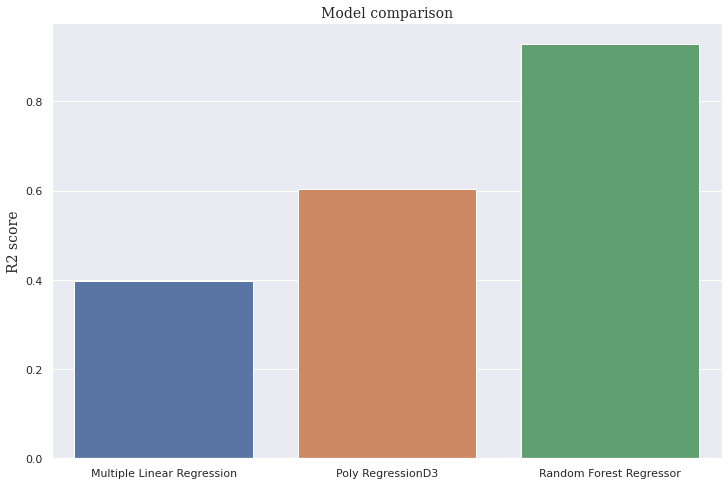

In [99]:
model_names = ['Multiple Linear Regression' , 'Poly RegressionD3', 'Random Forest Regressor']
model_r2_scores = [r2_PoReg, r2_PoFe, r2_RaFo]

plt.figure(figsize = (12,8))
sns.barplot(x = model_names , y = model_r2_scores)
plt.title("Model comparison" , fontdict = {'family':'serif' , 'size':14})
plt.ylabel("R2 score" , fontdict = {'family':'serif' , 'size':14})

Text(0, 0.5, 'RMSLE score')

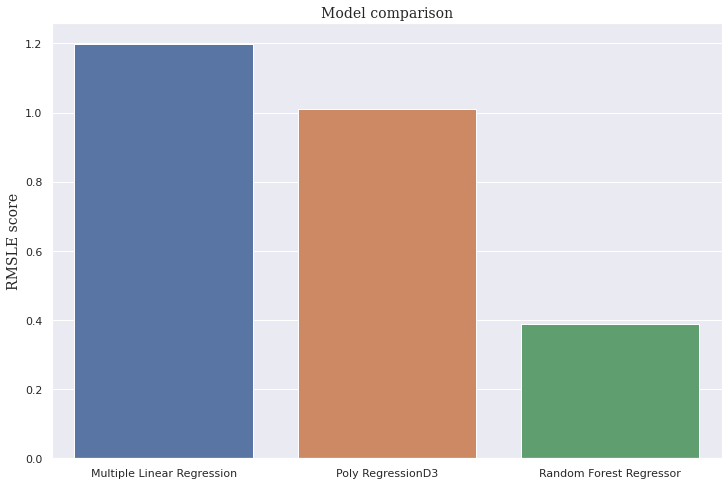

In [98]:
model_names = ['Multiple Linear Regression' , 'Poly RegressionD3', 'Random Forest Regressor']
model_r2_scores = [kaggle_score_PoReg, kaggle_score_PoFe, kaggle_score_RaFo]

plt.figure(figsize = (12,8))
sns.barplot(x = model_names , y = model_r2_scores)
plt.title("Model comparison" , fontdict = {'family':'serif' , 'size':14})
plt.ylabel("RMSLE score" , fontdict = {'family':'serif' , 'size':14})

## 8. Submitting prediction to Kaggle

In [68]:
#getting Kaggle test file
final_test = pd.read_csv('../data/test.csv', index_col=0, parse_dates=True)

In [69]:
final_test.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [ ]:
# temp, humidity, hour, month, year, weekday, weather 

In [70]:
## Transforming Final test file 
# Extracting hour, weekday, month and year from datetime 
final_test['hour'] = final_test.index.hour
final_test['weekday'] = final_test.index.weekday
final_test['month'] = final_test.index.month
final_test['year'] = final_test.index.year    

In [71]:
final_test.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,month,year
datetime,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,3,1,2011
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,3,1,2011


In [72]:
final_test = final_test.drop(train_set[['season', 'holiday', 'workingday', 'atemp', 'windspeed']], axis=1)


In [73]:
final_test.head(2)

,weather,temp,humidity,hour,weekday,month,year
datetime,,,,,,,
2011-01-20 00:00:00,1,10.66,56,0,3,1,2011
2011-01-20 01:00:00,1,10.66,56,1,3,1,2011


In [78]:
# final_test['weather'].value_counts()

In [74]:
final_test_fe = column_transformer.transform(final_test)

In [83]:
y_pred_final_test = RaFo.predict(final_test_fe) 

In [86]:
y_pred_final_test

array([  9.57,   4.25,   4.8 , ..., 156.69, 117.46,  70.79])

In [87]:
predictions = pd.DataFrame({'dateTime': final_test.index, 'count': y_pred_RaFo})
predictions.to_csv('predictions.csv',index=False) 

In [110]:
predictions.head(2)

,dateTime,count
0,2011-01-20 00:00:00,9.57
1,2011-01-20 01:00:00,4.25
